In [185]:
import librosa
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, Dataset

from pydub import AudioSegment
import soundfile as sf

import matplotlib.pyplot as plt
import librosa.display

In [186]:
def process_wavs_to_mel(input_dir='data1', output_dir='spectrograms', sr=44000, n_mels=64, duration=5):
    os.makedirs(output_dir, exist_ok=True)
    for fname in os.listdir(input_dir):
        if not fname.endswith('.wav'):
            continue
        path = os.path.join(input_dir, fname)
        y, _ = librosa.load(path, sr=sr)
        y = y[:sr * duration]  # clip or pad
        if len(y) < sr * duration:
            y = np.pad(y, (0, sr * duration - len(y)))
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)  # [n_mels, T]
        mel_db = mel_db.T  # [T, n_mels] → VAE expects time first
        out_path = os.path.join(output_dir, fname.replace('.wav', '.npy'))
        np.save(out_path, mel_db)


In [187]:
class MelDataset(Dataset):
    def __init__(self, mel_dir):
        self.files = [os.path.join(mel_dir, f) for f in os.listdir(mel_dir) if f.endswith('.npy')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = np.load(self.files[idx])  # shape: [T, 64]
        mel = (mel + 80.0) / 80.0  # scale from [-80, 0] dB to [0, 1]
        mel = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # [1, T, 64]
        return mel


In [188]:
class VAE(nn.Module):
    def __init__(self, input_dim=(157, 64), latent_dim=32):
        super().__init__()
        c, t = input_dim  # (mel bins, time)

        # Split encoder into conv layers and flatten
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(self.encoder_conv, self.flatten)

        # Compute decoder shape BEFORE flattening
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, c, t)
            features = self.encoder_conv(dummy_input)
            self.decoder_shape = features.shape[1:]  # (channels, height, width)
            self.enc_out_dim = features.view(1, -1).size(1)
            print(f"decoder_shape: {self.decoder_shape} → flattened: {self.enc_out_dim}")

        # Latent space mappings
        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.enc_out_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )




    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(z.size(0), *self.decoder_shape)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [189]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    _, _, H, W = x.shape
    x_recon = x_recon[:, :, :H, :W]  # Crop if needed

    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    
    # Clamp logvar to avoid nan in exp()
    logvar = torch.clamp(logvar, min=-10, max=10)

    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_loss, recon_loss, kl_loss


In [190]:
process_wavs_to_mel('data1', 'spectrograms', duration=7)
dataset = MelDataset("spectrograms/")
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [191]:
# === Get Actual Input Size from Dataset ===
sample_batch = next(iter(train_loader))  # e.g., [B, 1, 64, T]
mel_dim, time_dim = sample_batch.shape[-2], sample_batch.shape[-1]
print(f"Input mel shape: {mel_dim} x {time_dim}")

# === Create VAE Model with Correct Input Shape ===
model = VAE(input_dim=(mel_dim, time_dim), latent_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# === Training Loop ===
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    beta = min(1.5, epoch / 5)  # go higher than 1 if needed


    for x_batch in train_loader:
        x_batch = x_batch.to(device)
        x_recon, mu, logvar = model(x_batch)
        loss, recon, kl = vae_loss(x_recon, x_batch, mu, logvar, beta=beta)

        # Safety check
        if torch.isnan(loss) or torch.isinf(loss) or loss.item() == 0:
            print("⚠️ Skipping NaN or zero loss batch")
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon / len(train_loader)
    avg_kl = total_kl / len(train_loader)

    print(f"Epoch {epoch+1:02d}: Loss={avg_loss:.4f}  Recon={avg_recon:.4f}  KL={avg_kl:.4f}  Beta={beta:.2f}")




Input mel shape: 602 x 64
decoder_shape: torch.Size([64, 151, 16]) → flattened: 154624
Epoch 01: Loss=0.1339  Recon=0.1339  KL=67.8473  Beta=0.00
Epoch 02: Loss=2.3082  Recon=0.0973  KL=11.0546  Beta=0.20
Epoch 03: Loss=0.1687  Recon=0.0880  KL=0.2017  Beta=0.40
Epoch 04: Loss=0.0857  Recon=0.0816  KL=0.0069  Beta=0.60
Epoch 05: Loss=0.0796  Recon=0.0775  KL=0.0027  Beta=0.80
Epoch 06: Loss=0.0773  Recon=0.0752  KL=0.0021  Beta=1.00
Epoch 07: Loss=0.0755  Recon=0.0735  KL=0.0016  Beta=1.20
Epoch 08: Loss=0.0741  Recon=0.0724  KL=0.0013  Beta=1.40
Epoch 09: Loss=0.0731  Recon=0.0715  KL=0.0010  Beta=1.50
Epoch 10: Loss=0.0720  Recon=0.0707  KL=0.0009  Beta=1.50
Epoch 11: Loss=0.0713  Recon=0.0702  KL=0.0007  Beta=1.50
Epoch 12: Loss=0.0706  Recon=0.0696  KL=0.0006  Beta=1.50
Epoch 13: Loss=0.0701  Recon=0.0692  KL=0.0006  Beta=1.50


KeyboardInterrupt: 

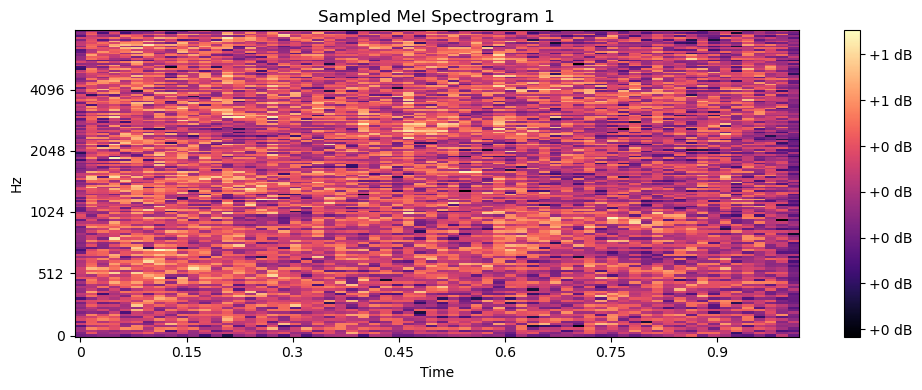

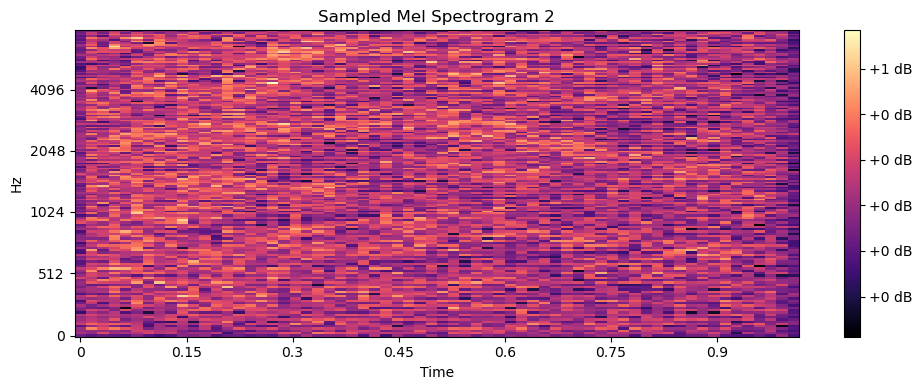

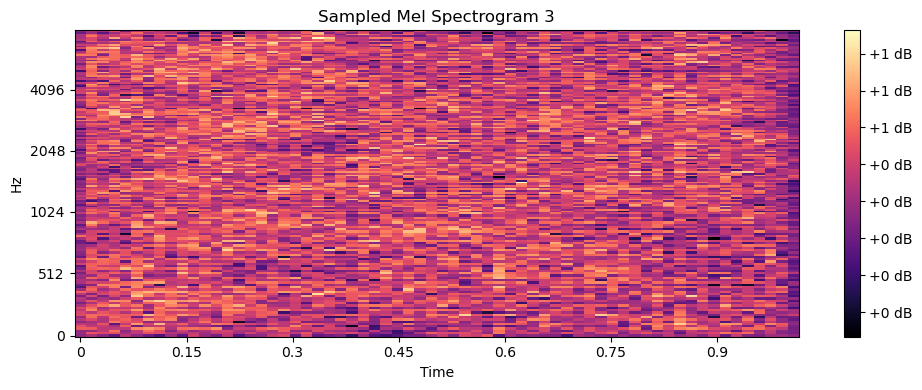

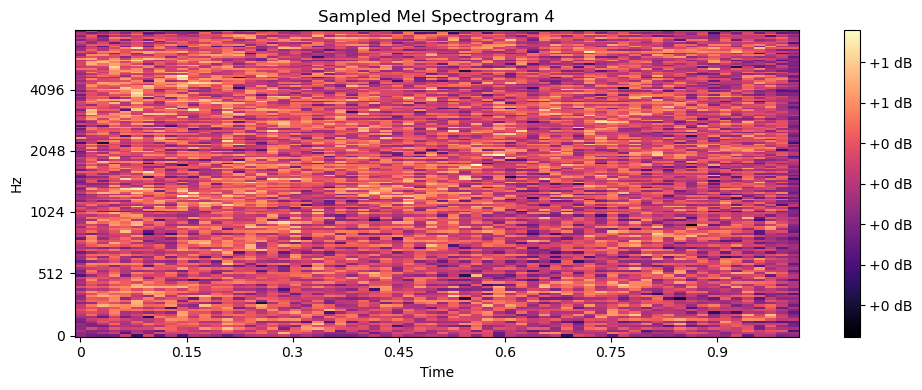

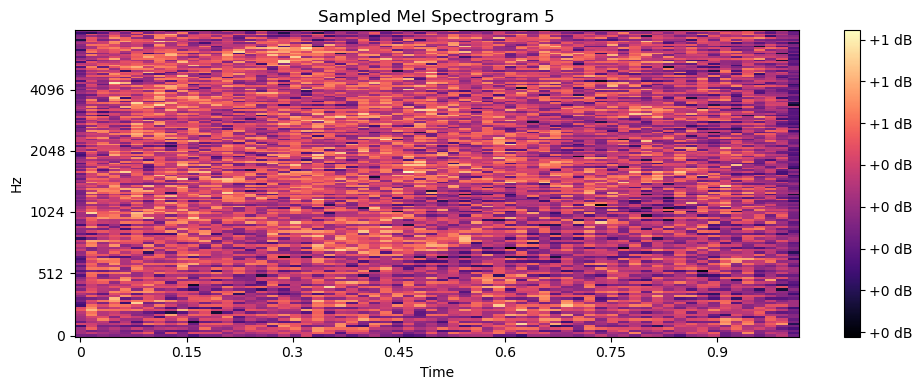

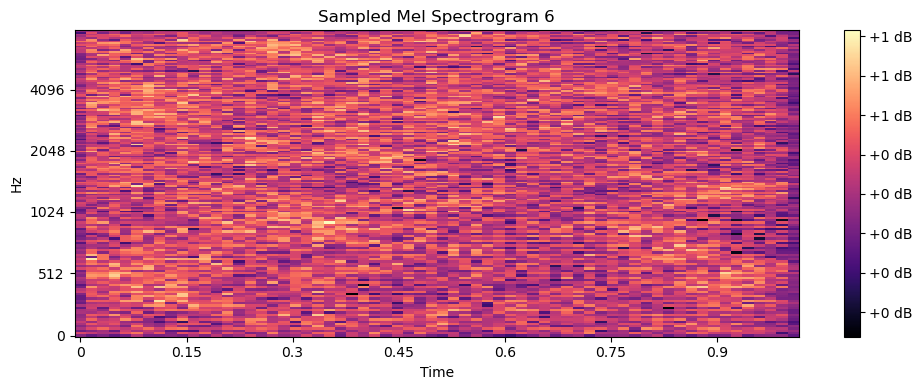

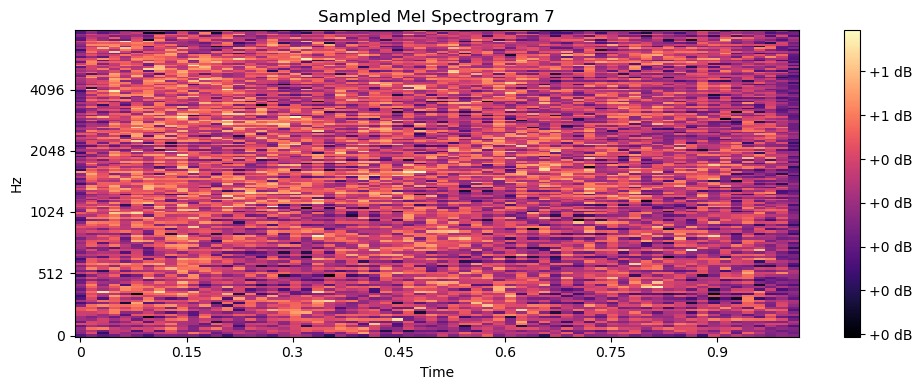

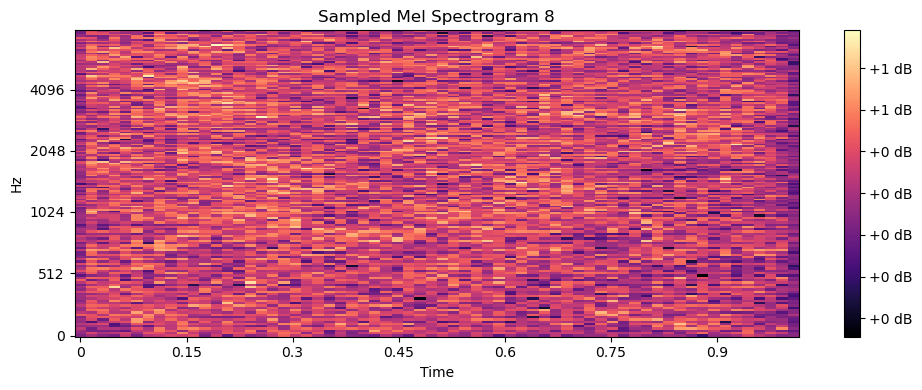

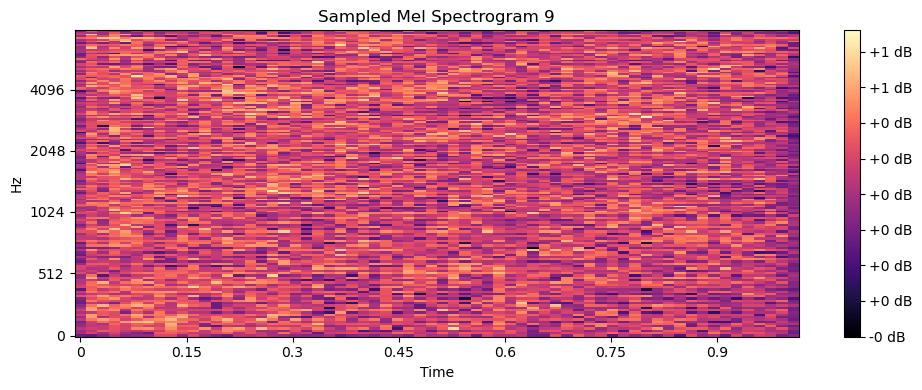

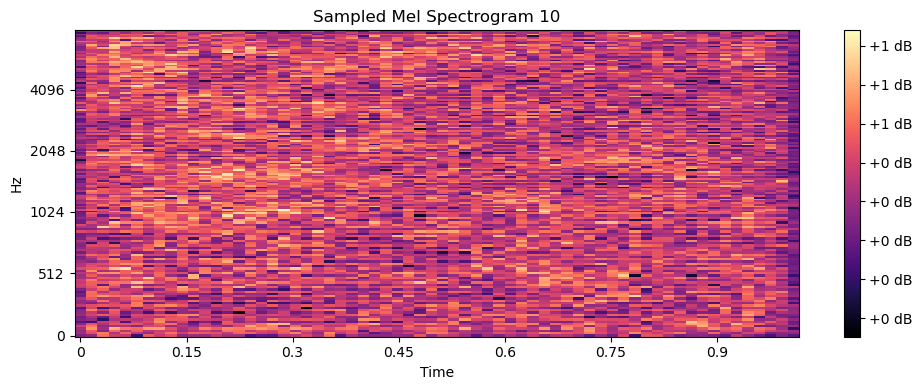

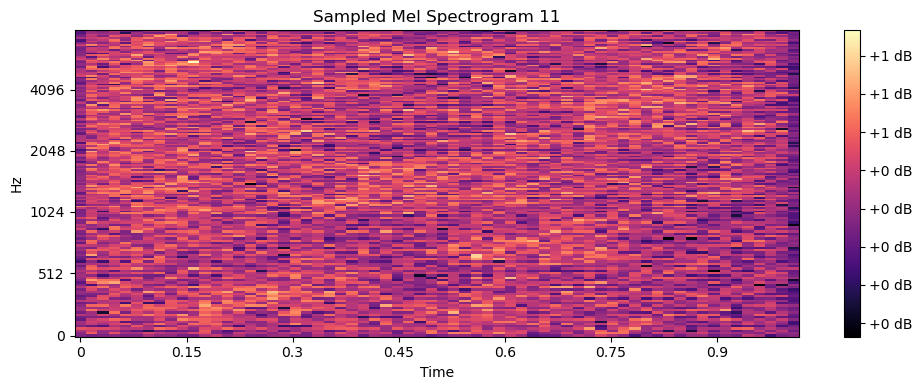

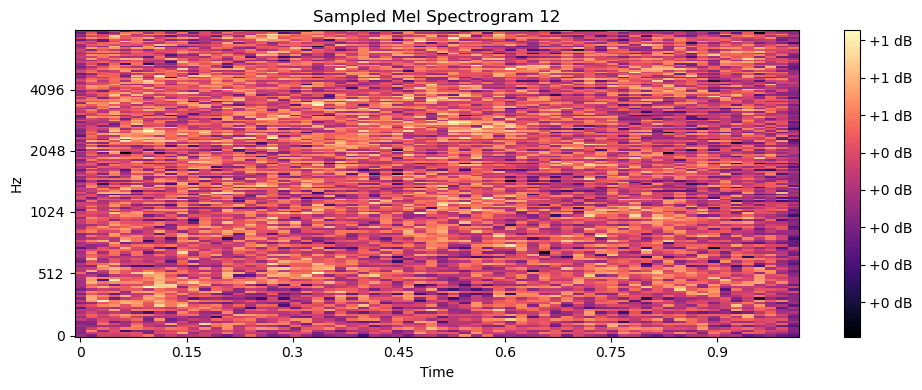

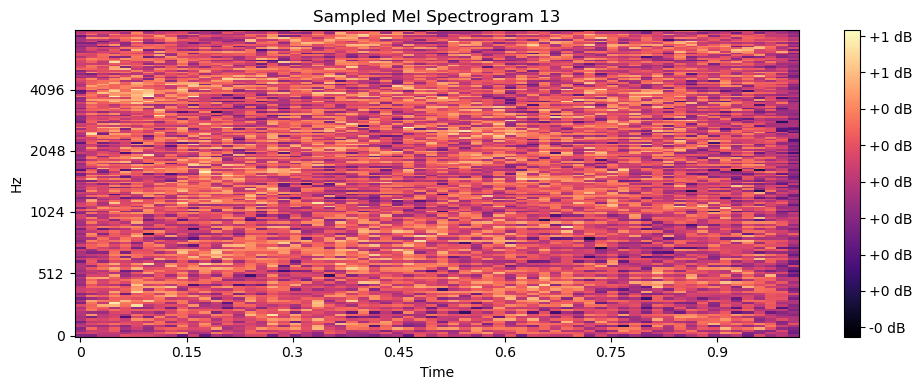

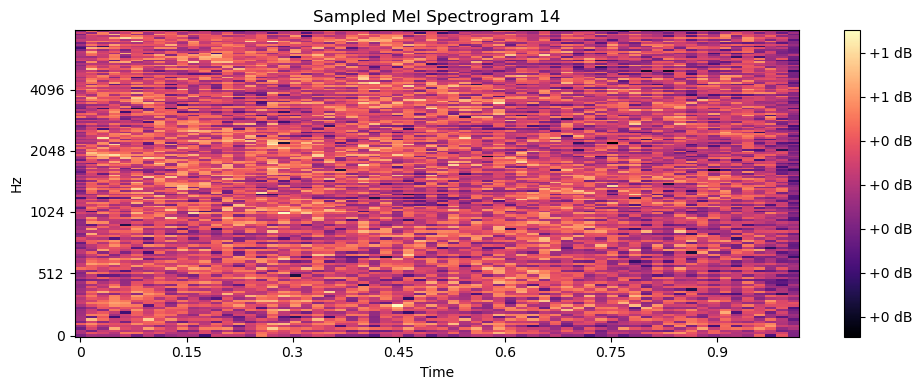

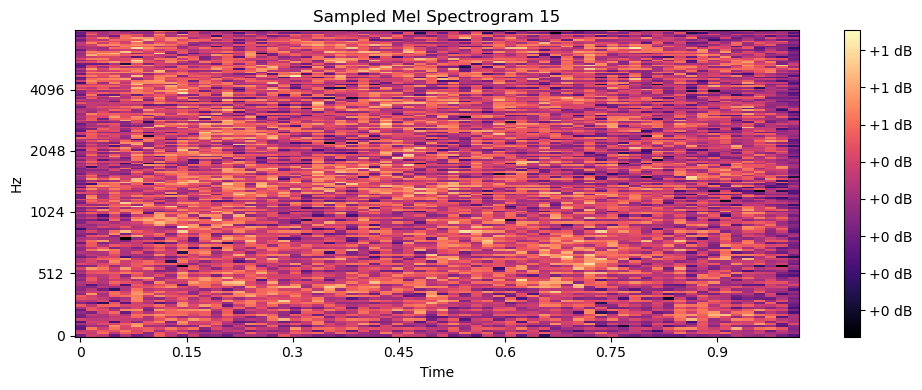

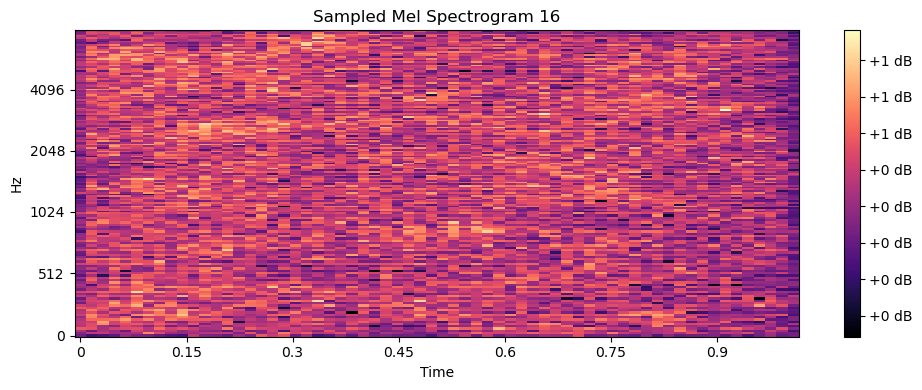

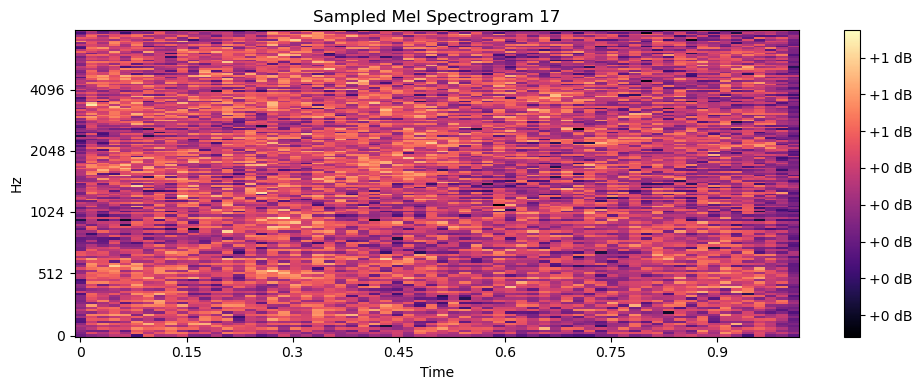

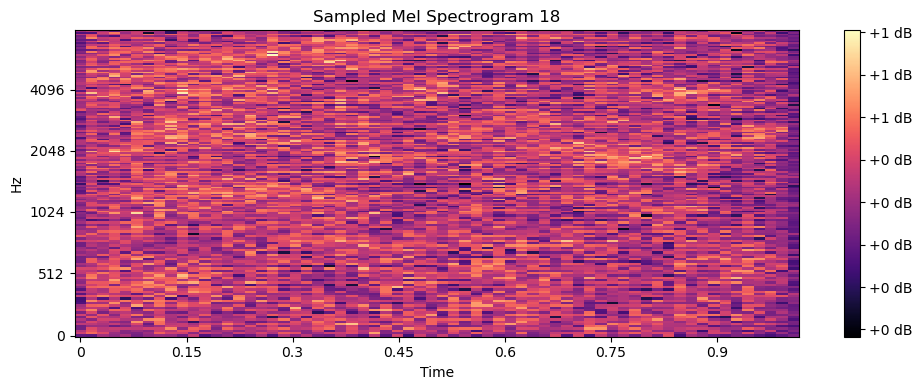

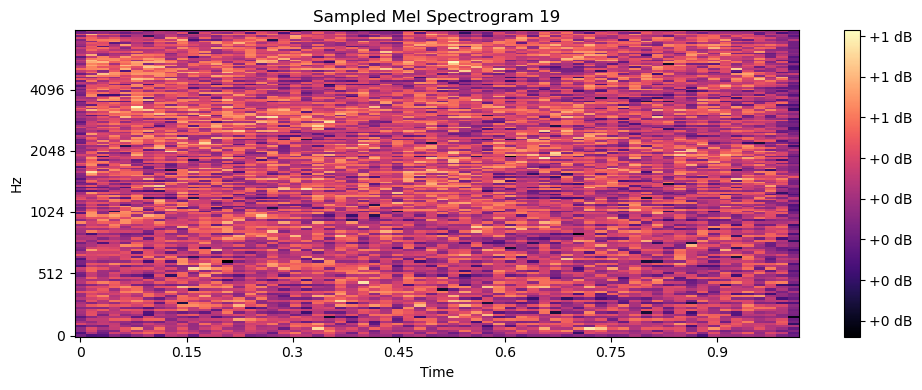

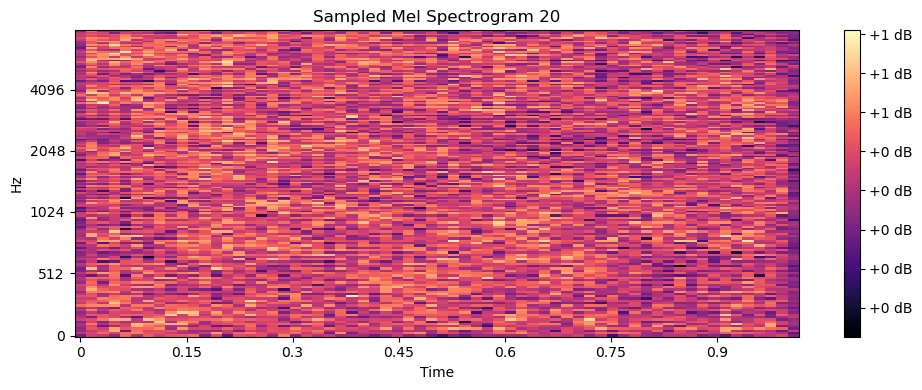

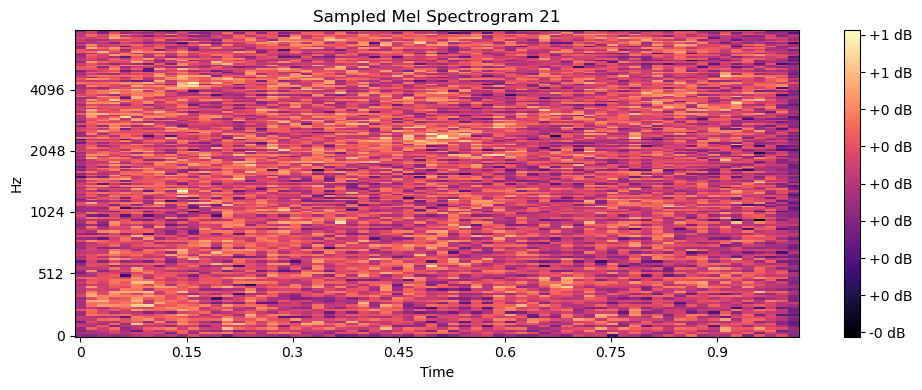

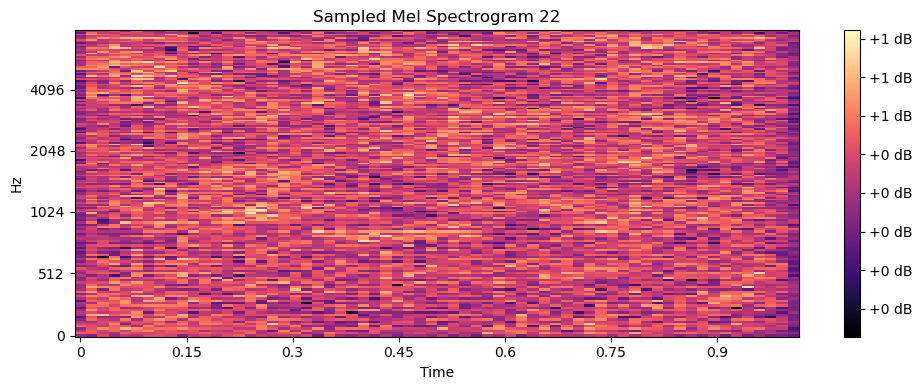

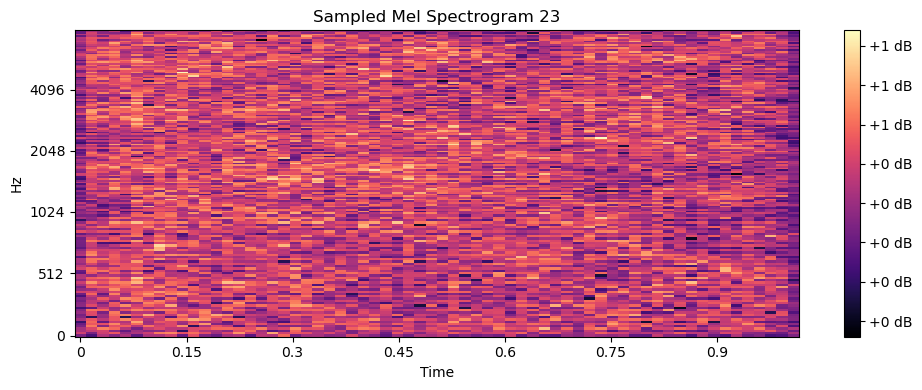

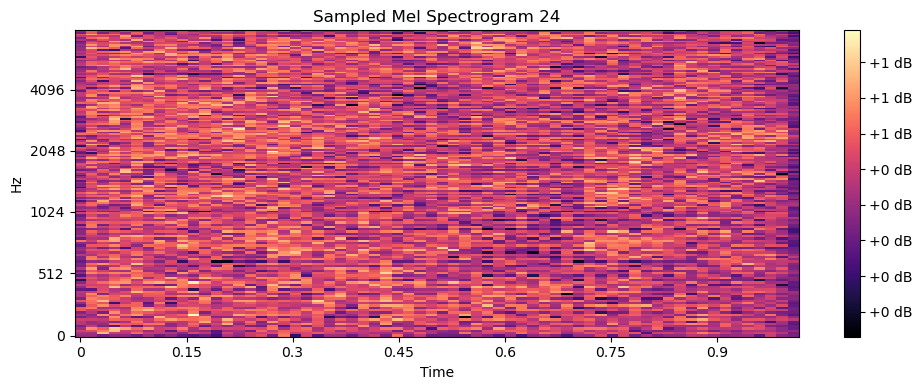

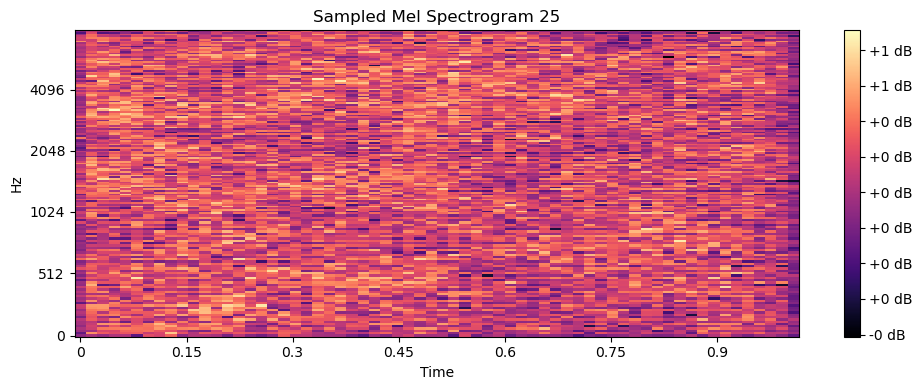

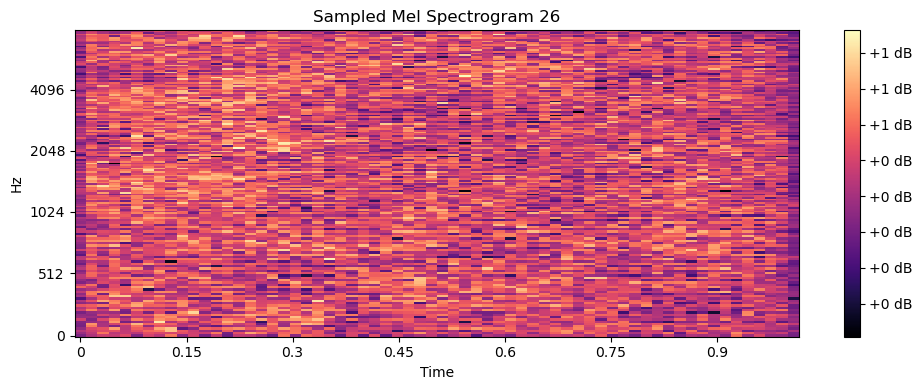

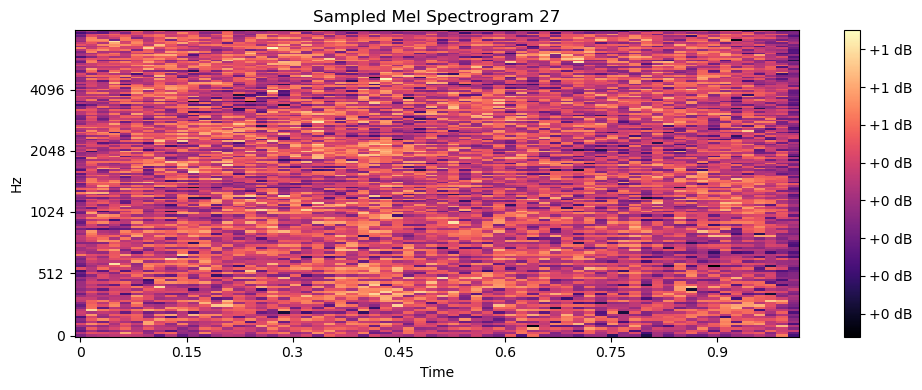

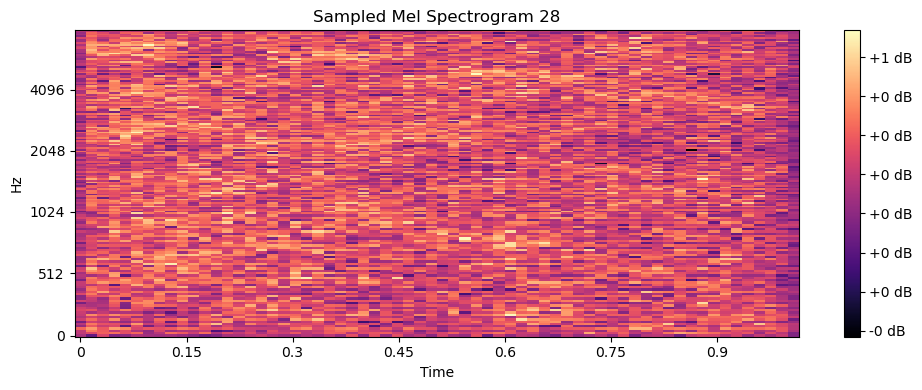

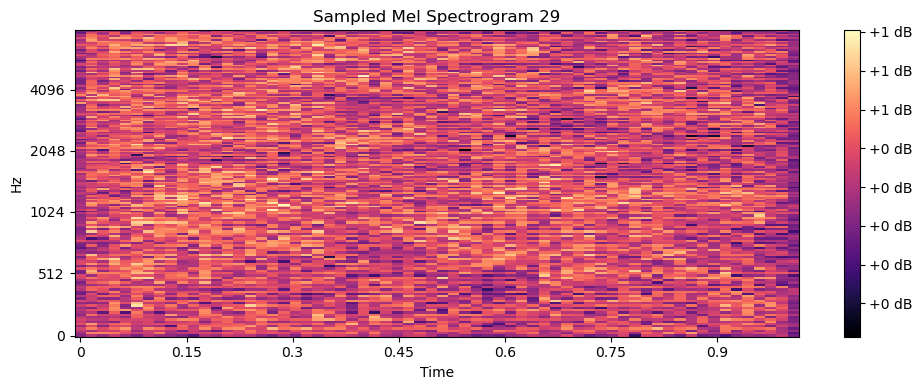

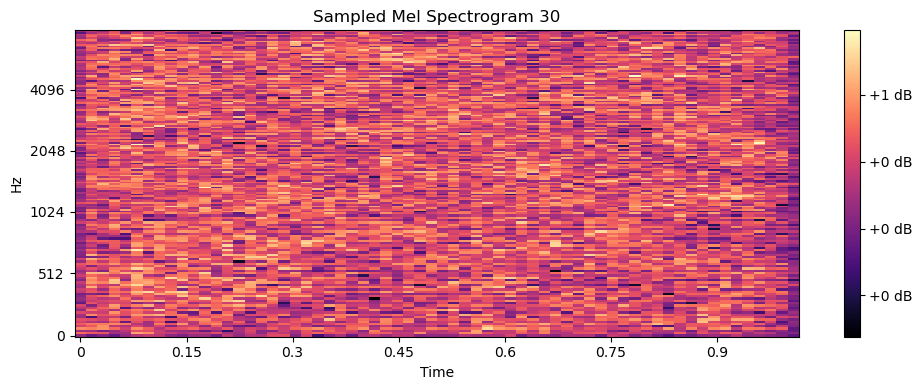

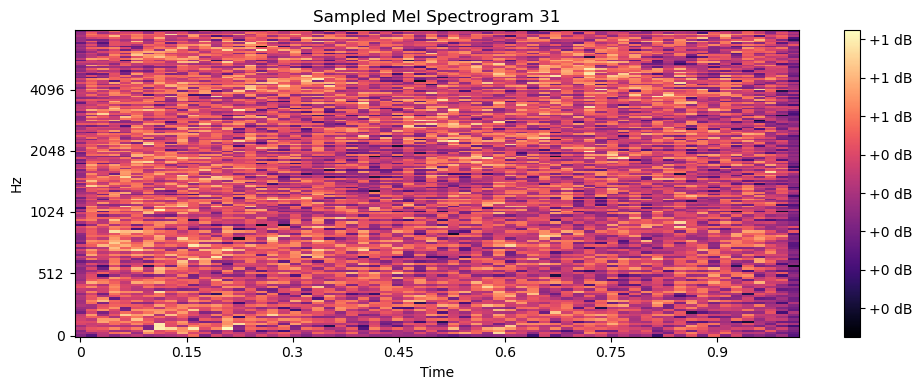

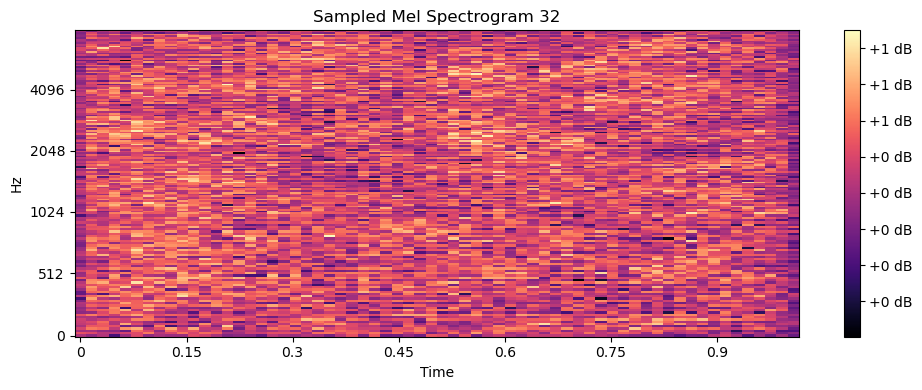

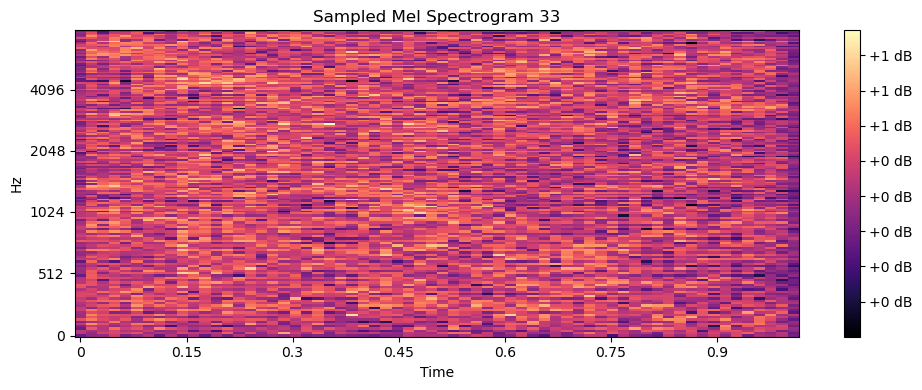

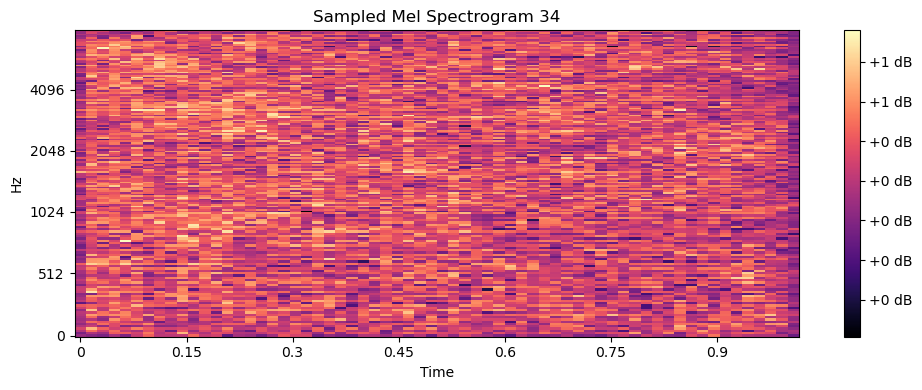

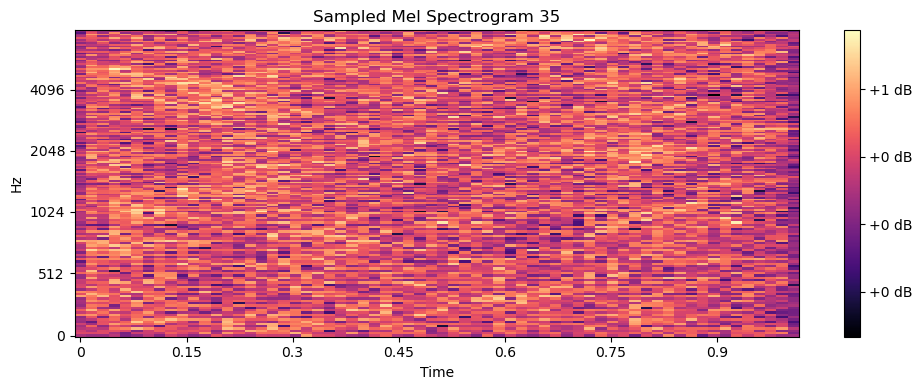

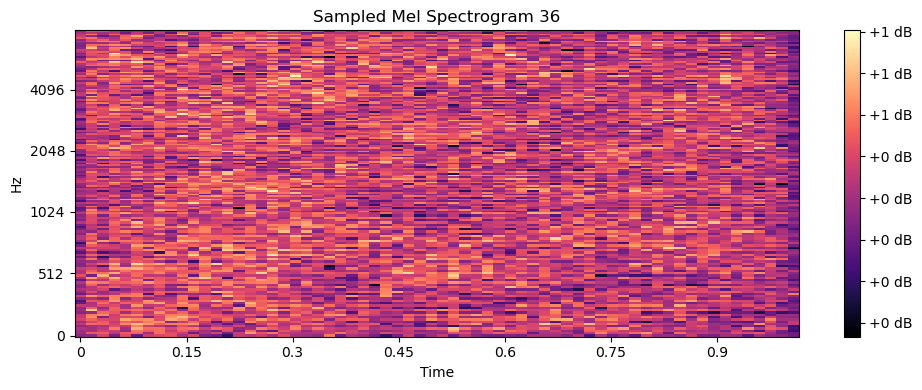

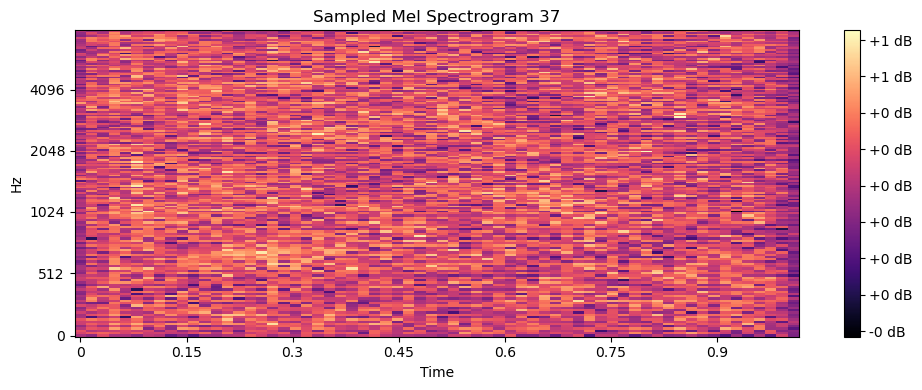

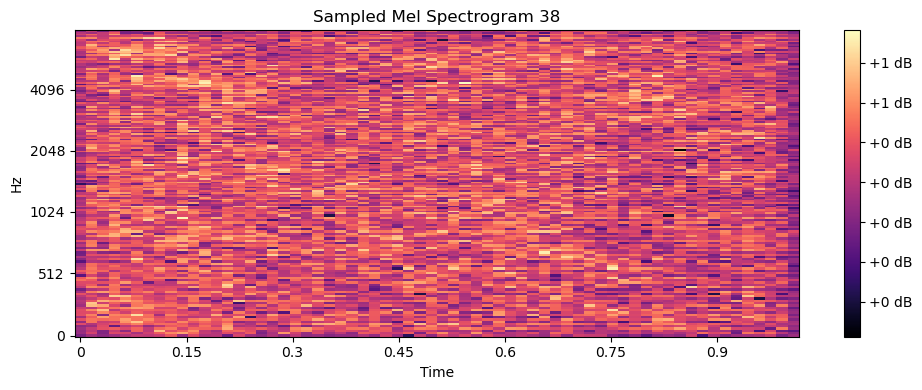

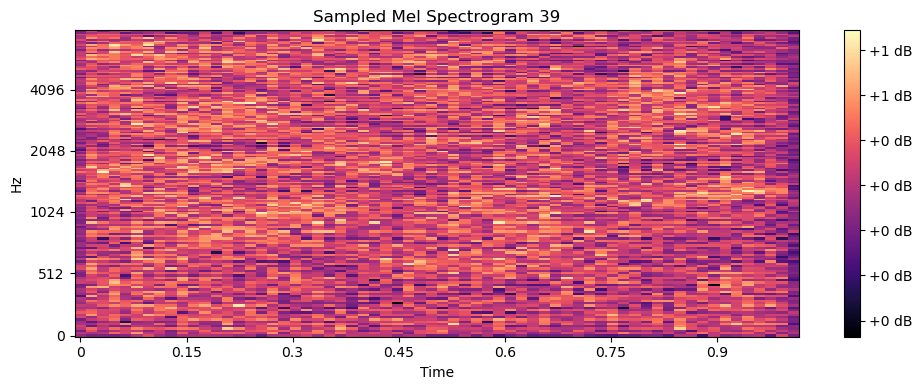

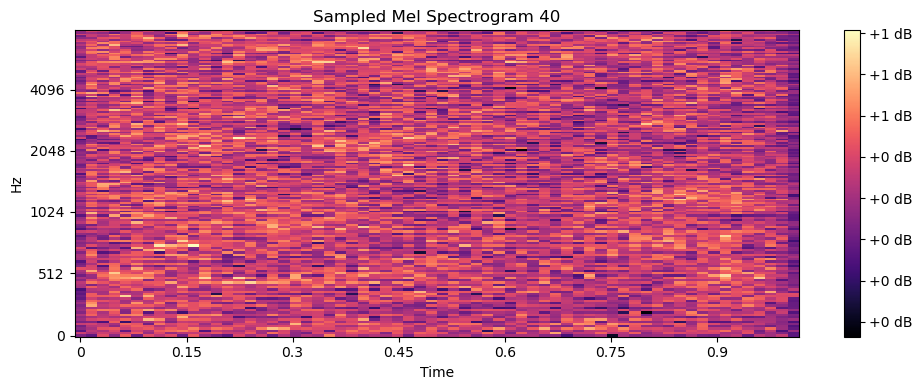

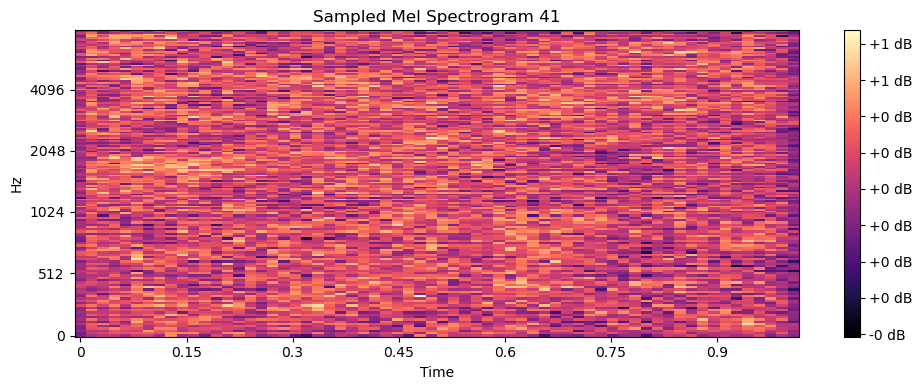

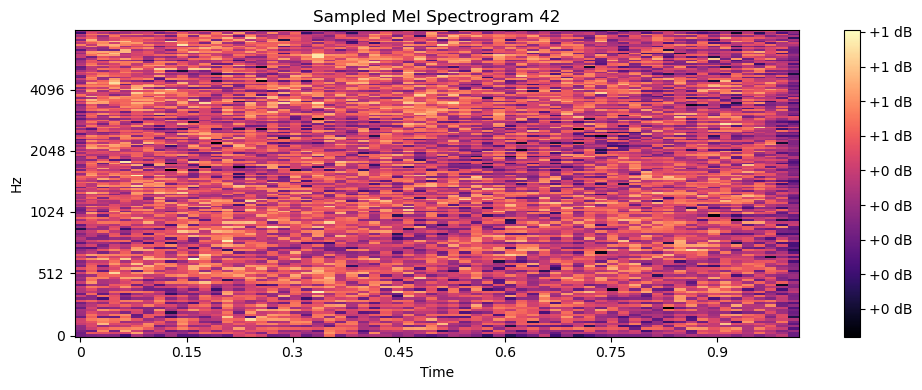

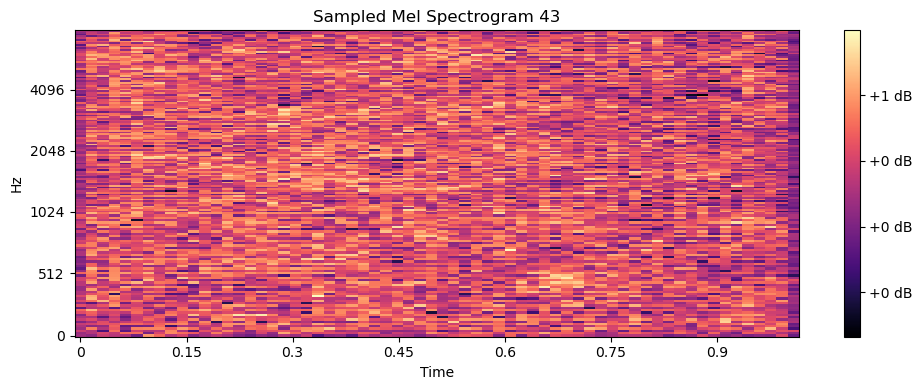

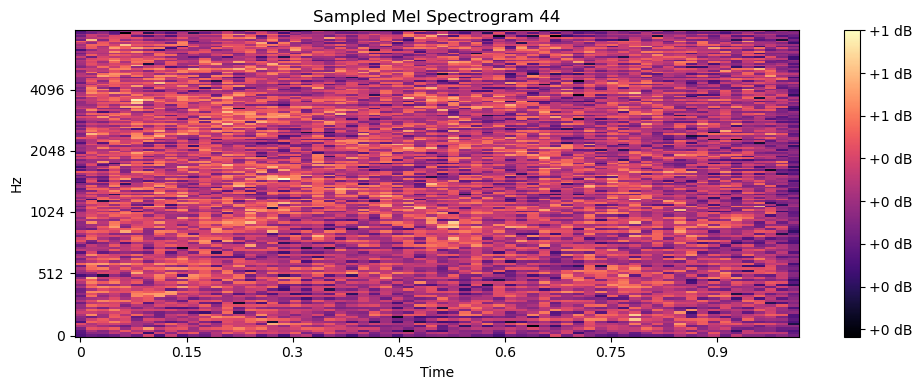

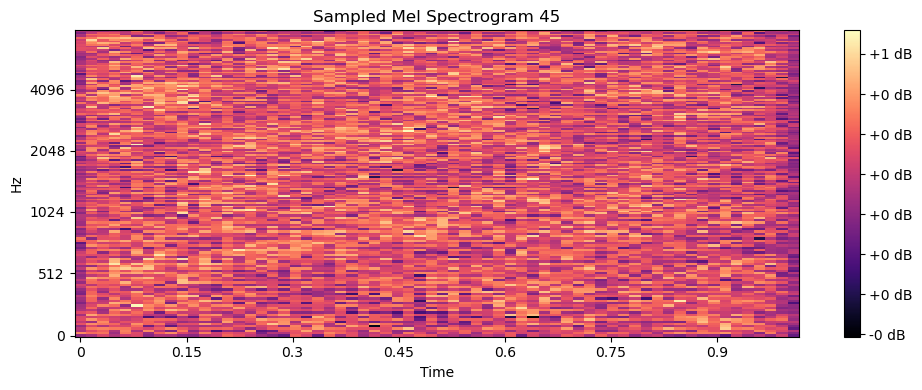

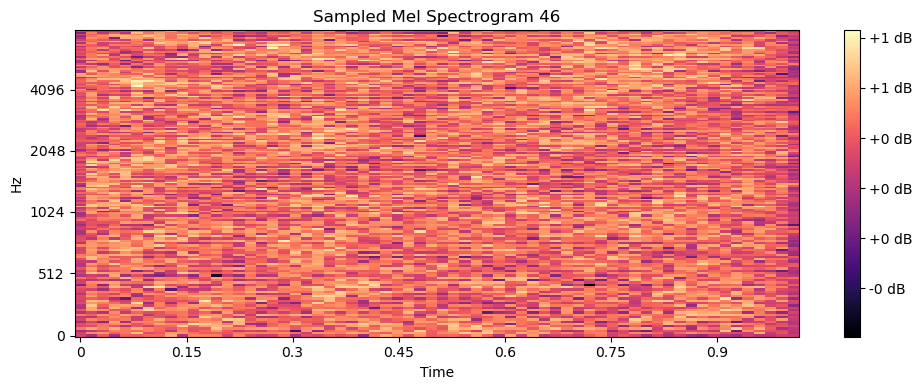

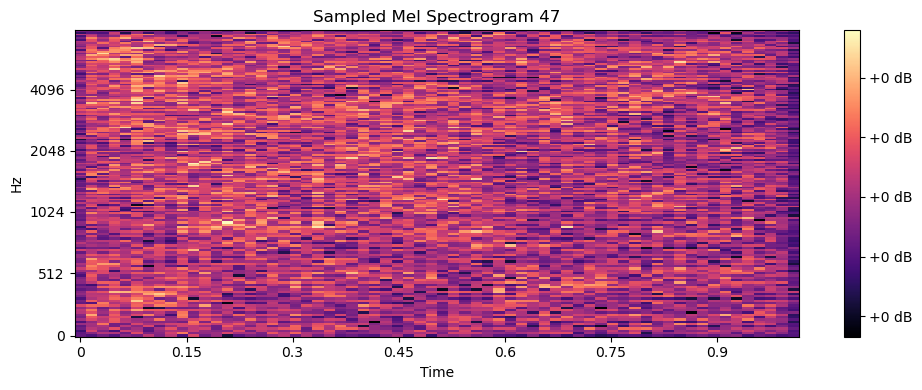

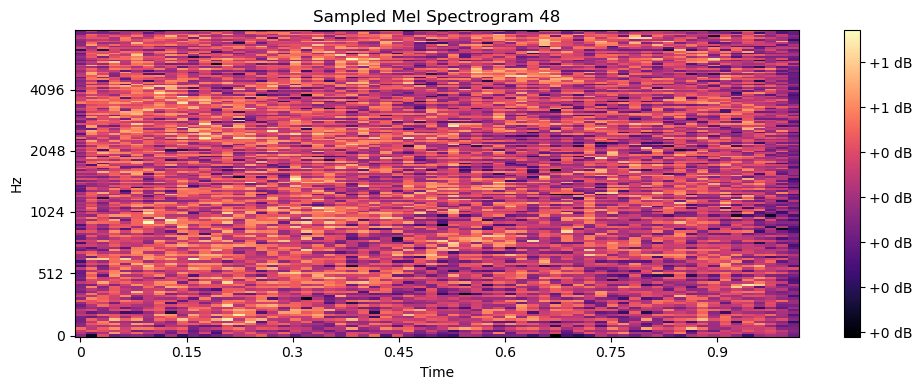

✅ Exported continuous_unconditioned.mp3 — duration: 48.4 seconds


In [ ]:
def generate_audio_sample(z_dim=128, sr=44000, target_duration=120):
    audio_clips = []
    model.eval()

    # === Generate one sample to estimate duration
    with torch.no_grad():
        z = torch.randn(1, z_dim).to(device)
        mel_out = model.decode(z).cpu().squeeze().numpy()

    time_steps = mel_out.shape[1]
    hop_length = 512
    clip_duration = time_steps * hop_length / sr
    n_samples = int(np.ceil(target_duration / clip_duration))

    print(f"⏱ Each clip ≈ {clip_duration:.2f}s → generating {n_samples} clips for ~{target_duration}s")

    for i in range(n_samples):
        with torch.no_grad():
            z = torch.randn(1, z_dim).to(device)
            mel_out = model.decode(z).cpu().squeeze().numpy()

        # === Visualize Mel
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_out, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
        plt.title(f"Sampled Mel Spectrogram {i+1}")
        plt.colorbar(format="%+2.0f dB")
        plt.tight_layout()
        plt.show()

        # === Convert from Tanh output
        mel_db = mel_out * 40.0
        mel_db = np.clip(mel_db, -80.0, 0.0)
        mel_power = librosa.db_to_power(mel_db)

        # === Invert to waveform
        audio = librosa.feature.inverse.mel_to_audio(
            mel_power, sr=sr, n_fft=1024, hop_length=hop_length, win_length=1024, n_iter=60
        )

        # === Save temp clip
        temp_path = f"temp_clips/temp_clip_{i}.wav"
        sf.write(temp_path, audio, sr)
        audio_clips.append(AudioSegment.from_wav(temp_path))

    # === Stitch and export final audio
    final_audio = sum(audio_clips)
    final_audio.export("continuous_unconditioned.mp3", format="mp3")
    print(f"✅ Exported continuous_unconditioned.mp3 — total duration: {final_audio.duration_seconds:.1f} seconds")

generate_audio_sample(z_dim=128, target_duration=120)  # 120s = 2 min
